In [ ]:
# from transformers import pipeline
# sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
# sentiment_task("Covid cases are increasing fast!")


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)



text = "Covid cases are increasing fast!"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


In [ ]:
import pandas as pd

# Load the sentiment dataset from the CSV file
file_path = '/content/output.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Ensure 'Date' and 'label' columns exist in the dataset
if 'Date' in data.columns and 'label' in data.columns and 'score' in data.columns:
    # Convert 'Date' column to datetime and extract only the date (for daily grouping)
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    # Assign weights: 1 for 'POSITIVE' and -1 for 'NEGATIVE' based on the 'label' column
    data['weight'] = data['label'].apply(lambda x: 1 if x == 'POSITIVE' else -1)

    # Multiply the 'score' by the 'weight' to get the weighted sentiment score
    data['weighted_score'] = data['score'] * data['weight']

    # Group the data by 'Date' and sum the weighted scores to get the net sentiment for each day
    net_sentiment_per_day = data.groupby('Date')['weighted_score'].sum().reset_index()

    # Rename the 'weighted_score' column to 'Net Sentiment'
    net_sentiment_per_day.columns = ['Date', 'Net Sentiment']

    # Save the result to a new CSV file
    net_sentiment_per_day.to_csv('result.csv', index=False)

# Load the Bitcoin price data
bitcoin_price_data = pd.read_csv('/content/bitcoin_price_data.csv')  # Replace with actual file path

# Ensure the 'Date' column in bitcoin_price_data is in the same format as in net_sentiment_per_day
bitcoin_price_data['Date'] = pd.to_datetime(bitcoin_price_data['Date']).dt.date

# Step 1: Add the 'delta' column, which calculates the difference between the current and next day's close price
bitcoin_price_data['delta'] = bitcoin_price_data['Close'].shift(-1) - bitcoin_price_data['Close']

# Step 2: For the last row, set the 'delta' value equal to the second last row
bitcoin_price_data.loc[bitcoin_price_data.index[-1], 'delta'] = bitcoin_price_data.loc[bitcoin_price_data.index[-2], 'delta']
bitcoin_price_data = bitcoin_price_data.drop(['Open', 'High', 'Low','Volume','Adj Close'], axis=1)
# Merge the sentiment data with the Bitcoin price data on the 'Date' column
merged_data = pd.merge(bitcoin_price_data, net_sentiment_per_day, on='Date', how='inner')

# Save the merged result to a new CSV file
merged_data.to_csv('/content/merged_data.csv', index=False)

# Print or return the result


merged_data=merged_data.drop(['Close'], axis=1)
print(merged_data.head())
merged_data.to_csv()



         Date        delta  Net Sentiment
0  2021-11-05   401.804688       1.060860
1  2021-11-06  1799.507812       0.983674
2  2021-11-08  -595.000000      -0.003928
3  2021-11-09 -1976.597656      -0.000482
4  2021-11-10   -45.269531      -0.000222


',Date,delta,Net Sentiment\n0,2021-11-05,401.8046875,1.06086007\n1,2021-11-06,1799.5078125,0.98367447\n2,2021-11-08,-595.0,-0.003928030000000082\n3,2021-11-09,-1976.59765625,-0.0004819099999998633\n4,2021-11-10,-45.26953125,-0.000222190000000011\n5,2021-11-11,-794.01953125,-2.0026441000000004\n6,2021-11-12,313.5859375,2.0002057200000003\n7,2021-11-14,-1908.96875,0.9988828\n8,2021-11-15,-3396.625,1.99358108\n9,2021-11-16,206.765625,3.98662589\n10,2021-11-17,-3425.875,3.6429185200000003\n11,2021-11-18,1177.44140625,0.04785633999999994\n12,2021-11-19,1577.6171875,-0.015291000000000055\n13,2021-11-20,-966.71875,0.9967147\n14,2021-11-22,1279.78515625,0.020965670000000047\n15,2021-11-23,-1288.6484375,3.9830784599999998\n16,2021-11-24,994.25390625,-0.99093195\n17,2021-11-25,-3704.9140625,3.97492233\n18,2021-11-26,1245.3125,1.9690461899999998\n19,2021-11-29,-801.140625,0.017190099999999986\n20,2021-11-30,224.40234375,1.9933787500000002\n21,2021-12-09,-428.81640625,1.9756983\n22,2021-12-10,2119

appling the sarima

In [ ]:
!pip install pandas statsmodels matplotlib


                   Close        delta  Net Sentiment
Date                                                
2021-11-05  61125.675781   401.804688     106.086007
2021-11-06  61527.480469  1799.507812      98.367447
2021-11-08  67566.828125  -595.000000      -0.392803
2021-11-09  66971.828125 -1976.597656      -0.048191
2021-11-10  64995.230469   -45.269531      -0.022219
...                  ...          ...            ...
2024-09-07  54139.687500   701.878906    -298.670959
2024-09-08  54841.566406  2177.968750     696.897752
2024-09-09  57019.535156   629.175781    1395.175548
2024-09-10  57648.710938  -305.539062    1992.148915
2024-09-11  57343.171875  -305.539062    -300.555291

[886 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              trend   No. Observations:                  696
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3493.688
Date:                            Sun, 06 Oct 2024   AIC                           6997.376
Time:                                    13:04:57   BIC                           7019.905
Sample:                                         0   HQIC                          7006.103
                                            - 696                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0619      0.029      2.133      0.033       0.005       0.119
ma.L1          1.0000     29.452   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

                                     SARIMAX Results                                      
Dep. Variable:                           seasonal   No. Observations:                  708
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                5840.651
Date:                            Sun, 06 Oct 2024   AIC                         -11671.303
Time:                                    13:05:01   BIC                         -11648.590
Sample:                                         0   HQIC                        -11662.519
                                            - 708                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0048   1.69e-14   2.85e+11      0.000       0.005       0.005
ma.L1          3.3875   8.64e-15   

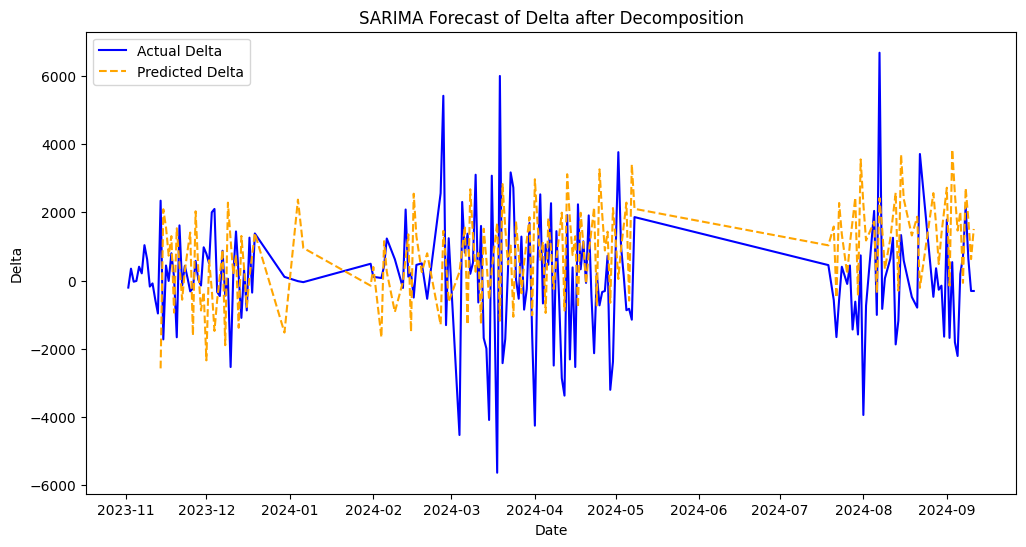

In [ ]:
# Load the merged data
merged_data = pd.read_csv('/content/merged_data.csv')

# Convert 'Date' column to datetime and set it as the index
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.set_index('Date', inplace=True)

# Multiply 'Net Sentiment' column by 100
merged_data['Net Sentiment'] = merged_data['Net Sentiment'] * 100

# Sort the data by date (if not already sorted)
merged_data = merged_data.sort_index()
print(merged_data)
# Step 1: Train-test split (80-20)
train_size = int(len(merged_data) * 0.8)
train_data = merged_data.iloc[:train_size]
test_data = merged_data.iloc[train_size:]

# Step 2: Decompose the 'delta' time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train_data['delta'], model='additive', period=12)  # Period could be monthly

# Extract the trend, seasonal, and residual components
trend_component = decomposition.trend.dropna()
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid.dropna()

# (Plotting skipped here for brevity)

# Step 3: Apply SARIMA to the trend component
trend_model = SARIMAX(trend_component,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

trend_fit = trend_model.fit(disp=False)
print(trend_fit.summary())

# Step 4: Apply SARIMA to the seasonal component
seasonal_model = SARIMAX(seasonal_component,
                         order=(1, 0, 1),
                         seasonal_order=(1, 0, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

seasonal_fit = seasonal_model.fit(disp=False)
print(seasonal_fit.summary())

# Step 5: Forecasting using SARIMA
n_steps = len(test_data)  # Number of steps to forecast
trend_forecast = trend_fit.get_forecast(steps=n_steps)
seasonal_forecast = seasonal_fit.get_forecast(steps=n_steps)

# Combine the forecasted trend and seasonal components
forecast_trend_values = trend_forecast.predicted_mean
forecast_seasonal_values = seasonal_forecast.predicted_mean

# Final forecast is the sum of the trend and seasonal components
final_forecast = forecast_trend_values + forecast_seasonal_values
final_forecast = final_forecast[:len(test_data)]

# Add forecasted values to the test set for comparison
test_data['Predicted_delta'] = ((final_forecast.values)*15-5500)

# Print correlation between delta and predicted delta
correlation = test_data[['delta', 'Predicted_delta']].corr()
print(correlation)

# Plot the actual vs predicted delta values
plt.figure(figsize=(12, 6))
plt.plot(test_data['delta'], label='Actual Delta', color='blue')
plt.plot(test_data['Predicted_delta'], label='Predicted Delta', color='orange', linestyle='--')
plt.title('SARIMA Forecast of Delta after Decomposition')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the time range
ticker_symbol = 'BTC-USD'
start_date = '2021-11-05'
end_date = '2024-09-12'

# Download the Bitcoin price data
btc_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Remove the "Volume" column
btc_data = btc_data.drop(columns=['Volume'])

# Calculate the delta (difference in 'Adj Close' between day d+1 and day d)
btc_data['Delta'] = btc_data['Adj Close'].diff().shift(-1)

# Label the Delta: 1 if the price increased, 0 if no change, and -1 if the price decreased
btc_data['Delta'] = btc_data['Delta'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Set the delta of the last day to 0 (since no next day exists)
btc_data['Delta'].iloc[-1] = 0

# Save the Bitcoin price data to a CSV file
btc_data.to_csv('bitcoin_price_data_with_delta.csv')

# Load the sentiment analysis dataset (make sure to specify the correct path)
sentiment_data = pd.read_csv('grouped_sentiment_with_net.csv')  # Replace with your actual file path

# Ensure the 'Date' column in sentiment_data is in datetime format
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Day'])  # Assuming 'Day' is the date column

# Merge the datasets on the date
merged_data = pd.merge(btc_data, sentiment_data, left_index=True, right_on='Date', how='inner')
merged_data = merged_data.drop(columns=['Day'])
# Save the merged dataset to a new CSV file
merged_data.to_csv('merged_bitcoin_sentiment_data.csv', index=False)

# Display the merged data
print(merged_data.head())
 # Using the 'columns' parameter


[*********************100%***********************]  1 of 1 completed

           Open          High           Low         Close     Adj Close  \
0  61460.078125  62541.468750  60844.609375  61125.675781  61125.675781   
1  61068.875000  61590.683594  60163.781250  61527.480469  61527.480469   
2  63344.066406  67673.742188  63344.066406  67566.828125  67566.828125   
3  67549.734375  68530.335938  66382.062500  66971.828125  66971.828125   
4  66953.335938  68789.625000  63208.113281  64995.230469  64995.230469   

   Delta  Negative  Positive  Net Sentiment Sentiment Label       Date  
0      1         2         3              1        Positive 2021-11-05  
1      1         0         1              1        Positive 2021-11-06  
2     -1         2         2              0         Neutral 2021-11-08  
3     -1         2         2              0         Neutral 2021-11-09  
4     -1         2         2              0         Neutral 2021-11-10  



<ipython-input-15-b326c375bbcd>:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  btc_data['Delta'].iloc[-1] = 0
<ipython-input-15-b326c375bbcd>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [ ]:
print(merged_data)

             Open          High           Low         Close     Adj Close  \
0    61460.078125  62541.468750  60844.609375  61125.675781  61125.675781   
1    61068.875000  61590.683594  60163.781250  61527.480469  61527.480469   
2    63344.066406  67673.742188  63344.066406  67566.828125  67566.828125   
3    67549.734375  68530.335938  66382.062500  66971.828125  66971.828125   
4    66953.335938  68789.625000  63208.113281  64995.230469  64995.230469   
..            ...           ...           ...           ...           ...   
881  53949.085938  54838.144531  53740.070312  54139.687500  54139.687500   
882  54147.933594  55300.859375  53653.757812  54841.566406  54841.566406   
883  54851.886719  58041.125000  54598.433594  57019.535156  57019.535156   
884  57020.097656  58029.976562  56419.414062  57648.710938  57648.710938   
885  57650.289062  57991.320312  55567.339844  57343.171875  57343.171875   

     Delta  Negative  Positive  Net Sentiment Sentiment Label       Date  
